-----
## Predicting Global Supply Chain Outcomes for Essential HIV Medicines using Machine Learning Methods
------

### Author: Tichakunda Mangono

### **Capstone Project, Udacity Machine Learning Engineer Nanodegree, September 2017**



- ***Key Question:*** *Can we use procurement transaction data to predict whether a delivery is delayed and estimating the length of the delay*
- ***Main Data Source:*** *From The Website: https://data.pepfar.net/additionalData. Procurement transaction data from the Supply Chain Management System (SCMS), administered by the United States Agency for International Development (USAID), provides information on health commodities, prices, and delivery destinations.*

# Notebook 2: Exploratory Data Analysis & Feature Selection

---
## 1. Exploratory Data Analysis (EDA)
---

In [1]:
import warnings; warnings.simplefilter('ignore')
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import my_helper_functions as mhf
import pandas_profiling as prof
import missingno as msno
import pivottablejs as pvt
import datetime as dt
import os
%matplotlib inline

### Load data

In [2]:
# Load in the data
_names =['dnum', 'dnum_country', 'dnum_vendor', 'dnum_factory', 'dnum_brand', 'dnum_molecule_test'
         , 'dnum_lpifsi', 'ddate', 'dobject','dtrend']
data_dict = mhf.load_clean_data(_names) 
print("Dataframes available: {} \n The data shapes: \n---{}".format(data_dict.keys()
                                                                    ,[d.shape for d in data_dict.values()]))
#Assign to named dataframes
dnum,dnum_country, dnum_vendor,dnum_factory,dnum_brand,dnum_molecule_test,dnum_lpifsi,ddate, dobject, dtrend = [data_dict[n] for n in _names]
dobject = dobject.apply(lambda x: pd.Categorical(x))
ddate['delivery_delay_time'] = ddate['delivery_delay_time'].apply(lambda x: pd.to_timedelta(x))

trying normal method for: ...  0
Sucess for: ...  0
trying normal method for: ...  1
Sucess for: ...  1
trying normal method for: ...  2
Sucess for: ...  2
trying normal method for: ...  3
Sucess for: ...  3
trying normal method for: ...  4
Sucess for: ...  4
trying normal method for: ...  5
Sucess for: ...  5
trying normal method for: ...  6
Sucess for: ...  6
trying normal method for: ...  7
Sucess for: ...  7
trying normal method for: ...  8
Failed with encoding error, trying again for: ...  8
Sucess for: ...  8
trying normal method for: ...  9
Sucess for: ...  9
Dataframes available: dict_keys(['dnum', 'dnum_country', 'dnum_vendor', 'dnum_factory', 'dnum_brand', 'dnum_molecule_test', 'dnum_lpifsi', 'ddate', 'dobject', 'dtrend']) 
 The data shapes: 
---[(10324, 9), (10324, 12), (10324, 12), (10324, 12), (10324, 12), (10324, 12), (10324, 24), (10324, 10), (10324, 64), (10324, 6)]


In [3]:
#dnum,dnum_country, dnum_vendor,dnum_factory,dnum_brand
#,dnum_molecule_test,dnum_lpifsi,ddate, dobject

### Univariate Profiling

In [4]:
#dnum,dnum_country, dnum_vendor,dnum_factory,dnum_brand
#,dnum_molecule_test,dnum_lpifsi,ddate, dobject
prof.ProfileReport(dnum_country)

Number of variables,12
Number of observations,10324
Total Missing (%),0.0%
Total size in memory,968.0 KiB
Average record size in memory,96.0 B
Numeric,10
Categorical,0
Date,0
Text (Unique),0
Rejected,2
Distinct count,217


#### Findings from profiling
#### dnum
- **line_itm_ins** is highly correlated with ln_itm_val (ρ = 0.95778), so these can be used interchangeably
    - but check to see if filled missing values are causing this as well
- unit_price is highly skewed (γ1 = 40.585)
    - will need to be log-transformed before scaling, standardization or normalizing
- ln_itm_freight_cost has a wide range of values
    - log-transform then scale
- 'units', 'ln_itm_qty', 'ln_itm_val', 'pk_price', 'ln_itm_weight', 'ln_itm_freight_cost'
    - all have wide ranges, log transforms
- Check to see if missing value imputation caused any big changes

#### dnum_country
- country_weightcount is highly correlated with **country_inscount**
- factory has a high cardinality: 88 distinct values Warning
- molecule_test has a high cardinality: 86 distinct values Warning
- vendor has a high cardinality: 73 distinct values Warning

#### dnum_vendor
- Similar findings to the other entity data - high correlations between price, weight and quantity variables

#### dnum_molecule_test
- Similar findings to the other entity data - high correlations between price, weight and quantity variables

#### dnum_factory
- Similar findings to the other entity data - high correlations between price, weight and quantity variables

#### dnum_brand
- Similar findings to the other entity data - high correlations between price, weight and quantity variables

### Multivariate Pivot Table

In [5]:
#dnum,dnum_country, dnum_vendor,dnum_factory,dnum_brand
#,dnum_molecule_test,dnum_lpifsi,ddate, dobject

# types =dobject.apply(lambda x: pd.lib.infer_dtype(x.values))
# types[types=='unicode']

#pvt.pivot_ui(pd.concat(dobject)

## Trends

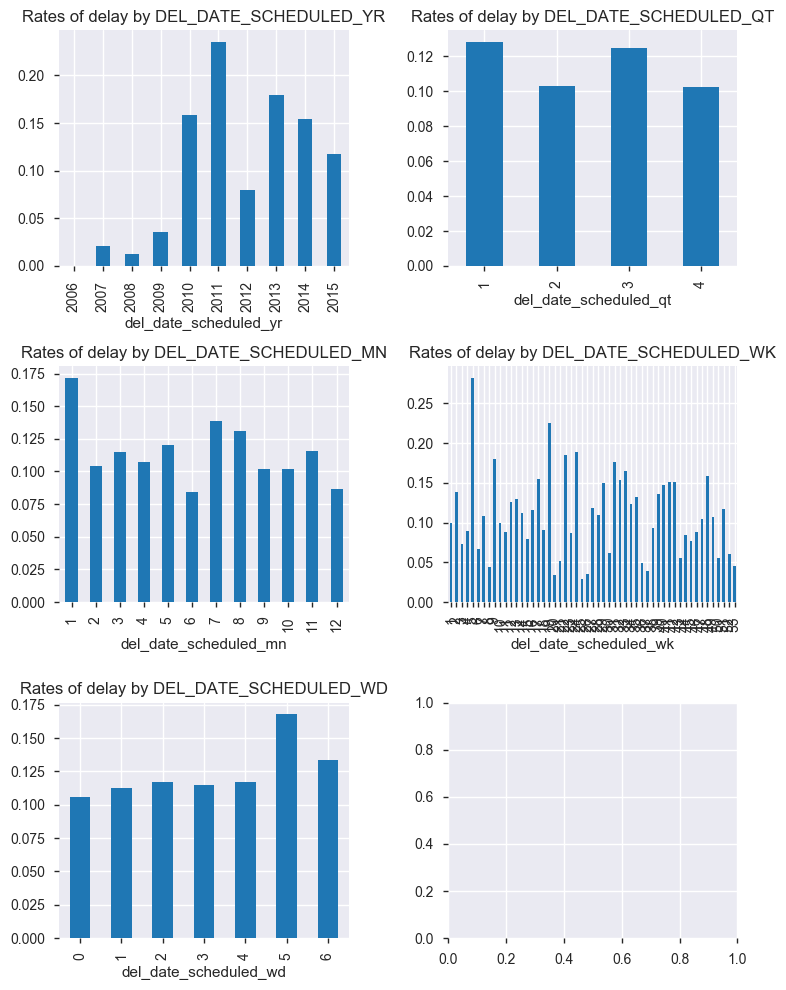

In [6]:
#### over time, can be done
dobject_del = dobject[[c for c in dobject.columns if "del" in c]]
for c in dobject_del:
    dobject_del[c] = pd.to_numeric(dobject_del[c])
# Plot
tcols = ['del_date_scheduled_yr','del_date_scheduled_qt'
 ,'del_date_scheduled_mn', 'del_date_scheduled_wk', 'del_date_scheduled_wd'] 
fig, ((ax0,ax1), (ax2,ax3),(ax4,ax5))= plt.subplots(nrows=3,ncols=2,figsize=(8,10))
axes = [ax0,ax1, ax2,ax3,ax4,ax5]
for i in range(len(tcols)):
    dobject_del.groupby(tcols[i]).agg('mean')['delayed'].plot(kind="bar", ax=axes[i]
                                        ,title = "Rates of delay by "+tcols[i].upper())
plt.tight_layout()

#### Findings from looking at the time element..
 
- More delays on items scheduled to arrive over the weekends, but is this significant?
- More delays on items scheduled to arrivein 2010,2011,2013, and 2014, but is this significant?
- Not much signal from the quarter in which we expect delivery to happen. 
    - All very close to the mean of 11.5%
- Looks like these weeks have somewhat high rates of delays 
    - 5, 9, 19, 22, 24
    - 31, 32, 33, 48
    - 40, 41, 42
- Looks like January has higher rates of delay than normal

### Time Series variations (Auto-Correlation)

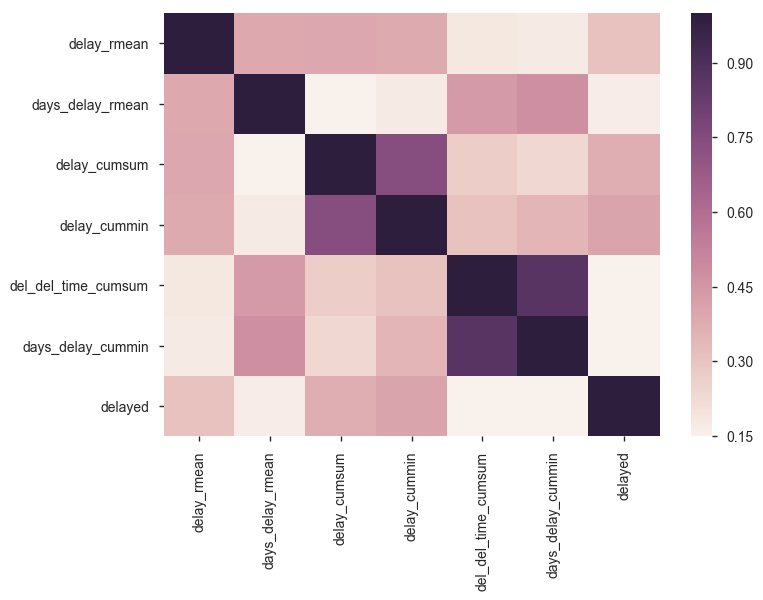

In [7]:
sns.heatmap(pd.concat([dtrend, dobject['delayed'].map({False:0, True:1})], axis=1).corr())

In [8]:
pd.concat([dtrend, dobject['delayed'].map({False:0, True:1})], axis=1).corr()

,delay_rmean,days_delay_rmean,delay_cumsum,delay_cummin,del_del_time_cumsum,days_delay_cummin,delayed
delay_rmean,1.000000,0.389493,0.391467,0.387232,0.178809,0.173494,0.307339
days_delay_rmean,0.389493,1.000000,0.151116,0.174494,0.438381,0.477774,0.162638
delay_cumsum,0.391467,0.151116,1.000000,0.743539,0.270325,0.235184,0.372863
delay_cummin,0.387232,0.174494,0.743539,1.000000,0.307309,0.345503,0.405849
del_del_time_cumsum,0.178809,0.438381,0.270325,0.307309,1.000000,0.872472,0.149018
days_delay_cummin,0.173494,0.477774,0.235184,0.345503,0.872472,1.000000,0.148712
delayed,0.307339,0.162638,0.372863,0.405849,0.149018,0.148712,1.000000


#### Findings - there are some very strong corelations with timeseries statistics, 
#### which signify the utility of using these for autocorrelation aspects

## Pair-wise Correlations 

In [9]:
delayed=dobject.delayed

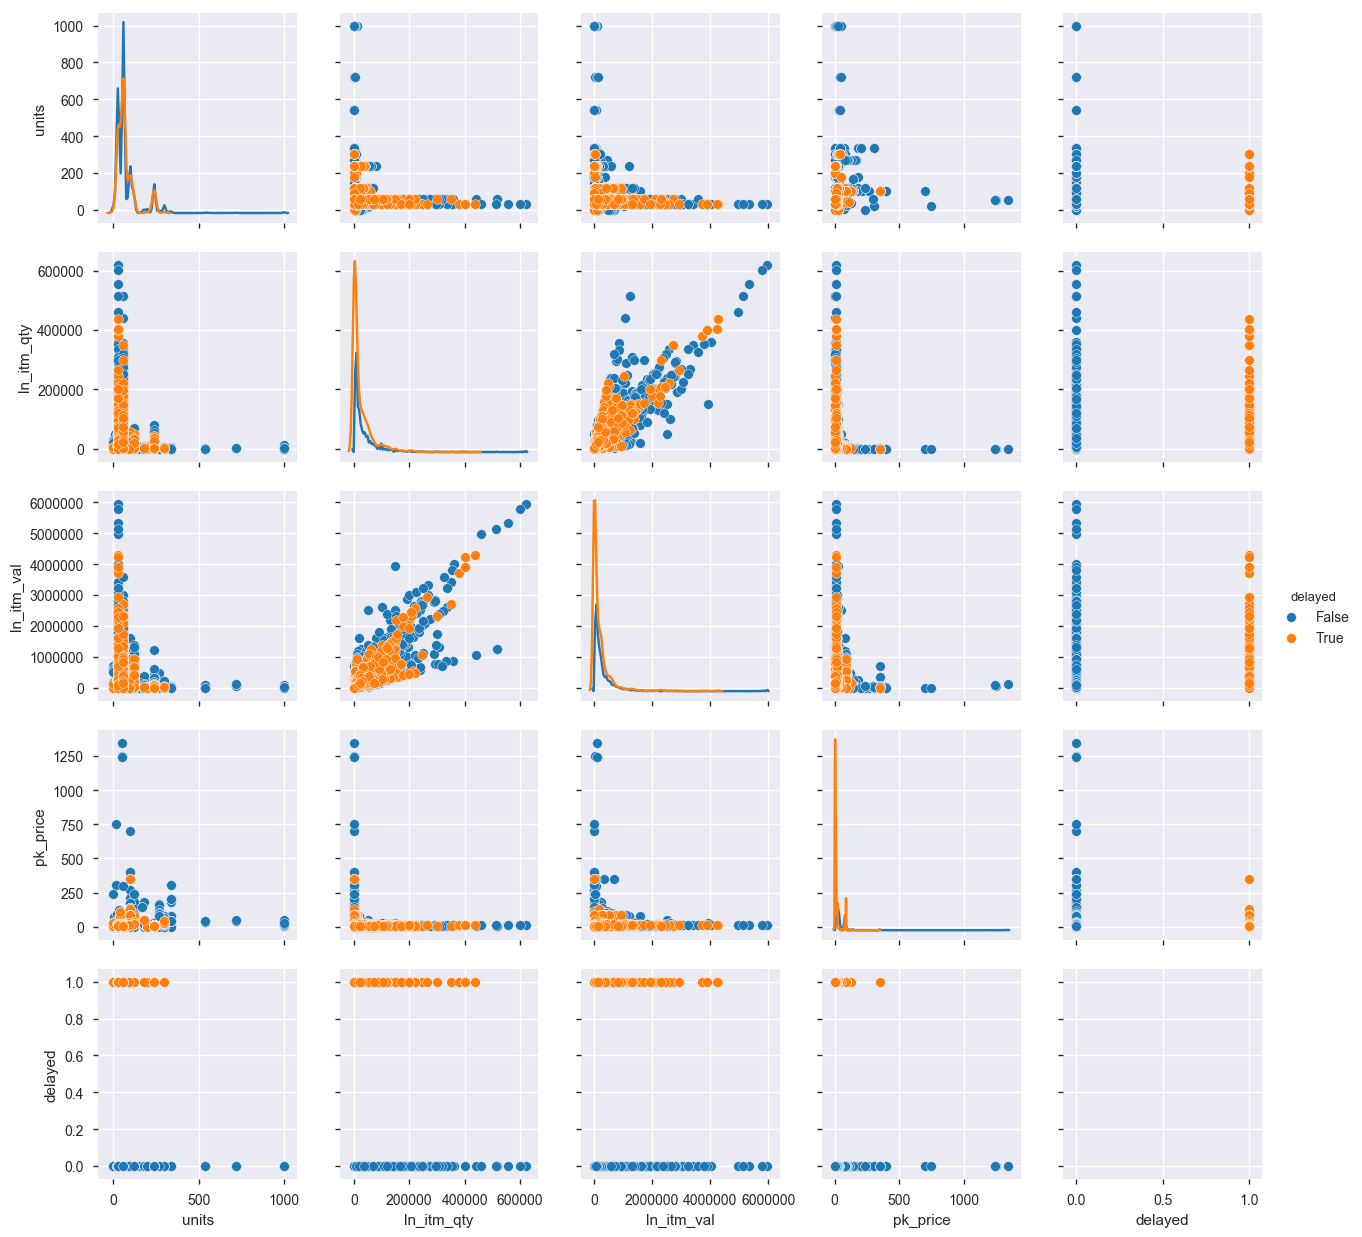

In [10]:
sns.pairplot(pd.concat([dnum.iloc[:,:5], delayed],axis=1).drop(['id'], axis=1)
             , hue="delayed",diag_kind="kde")

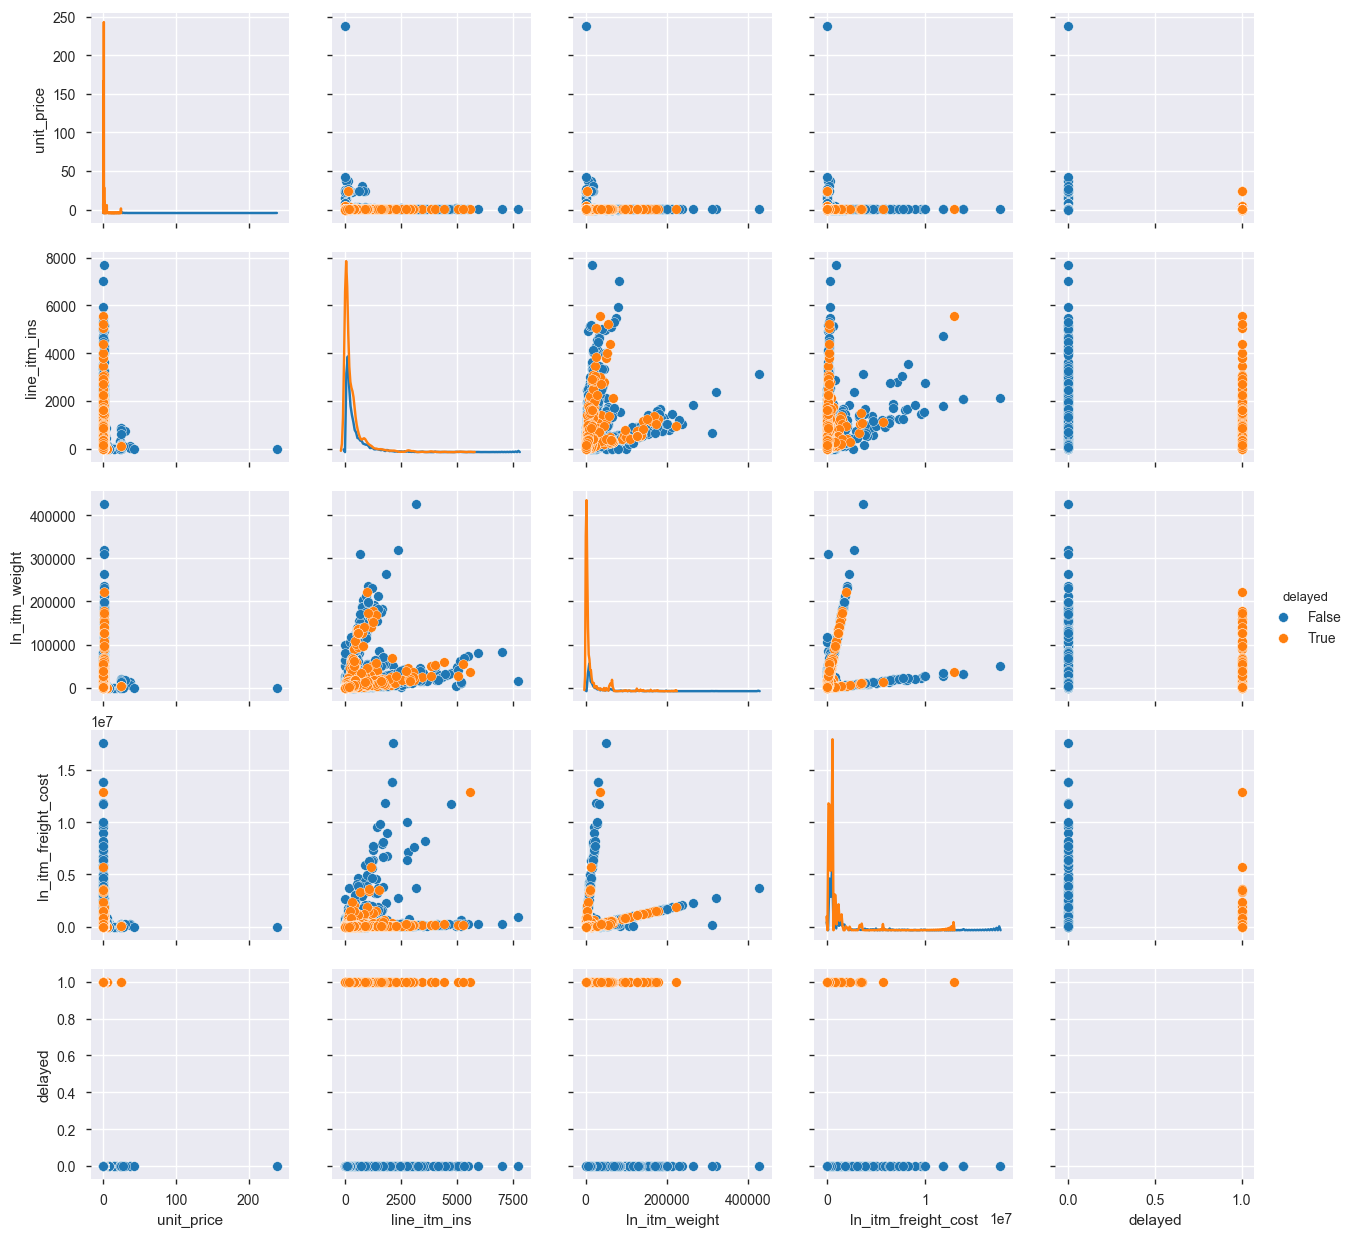

In [11]:
sns.pairplot(pd.concat([dnum.iloc[:,5:], delayed],axis=1), hue="delayed", diag_kind="kde")

#### Findings on pairwise numerical correlations

- individually, there is are wide distributions, will need to scale/log
- Price, weight, quantity, insurance have som high correlations with each other
- Some signal with delayed variable, generally on the lower side in terms of magnitude
- Weight, Cost e.g. have bifurcated relation which is linear but with two different slopes
    - 2 pricing systems/ bulk vs. single? generic? etc.

## Correlations to the target - Delayed

In [12]:
#dnum,dnum_country, dnum_vendor,dnum_factory,dnum_brand
#,dnum_molecule_test,dnum_lpifsi,ddate, dobject

In [13]:
delayed=pd.to_numeric(dobject.delayed)

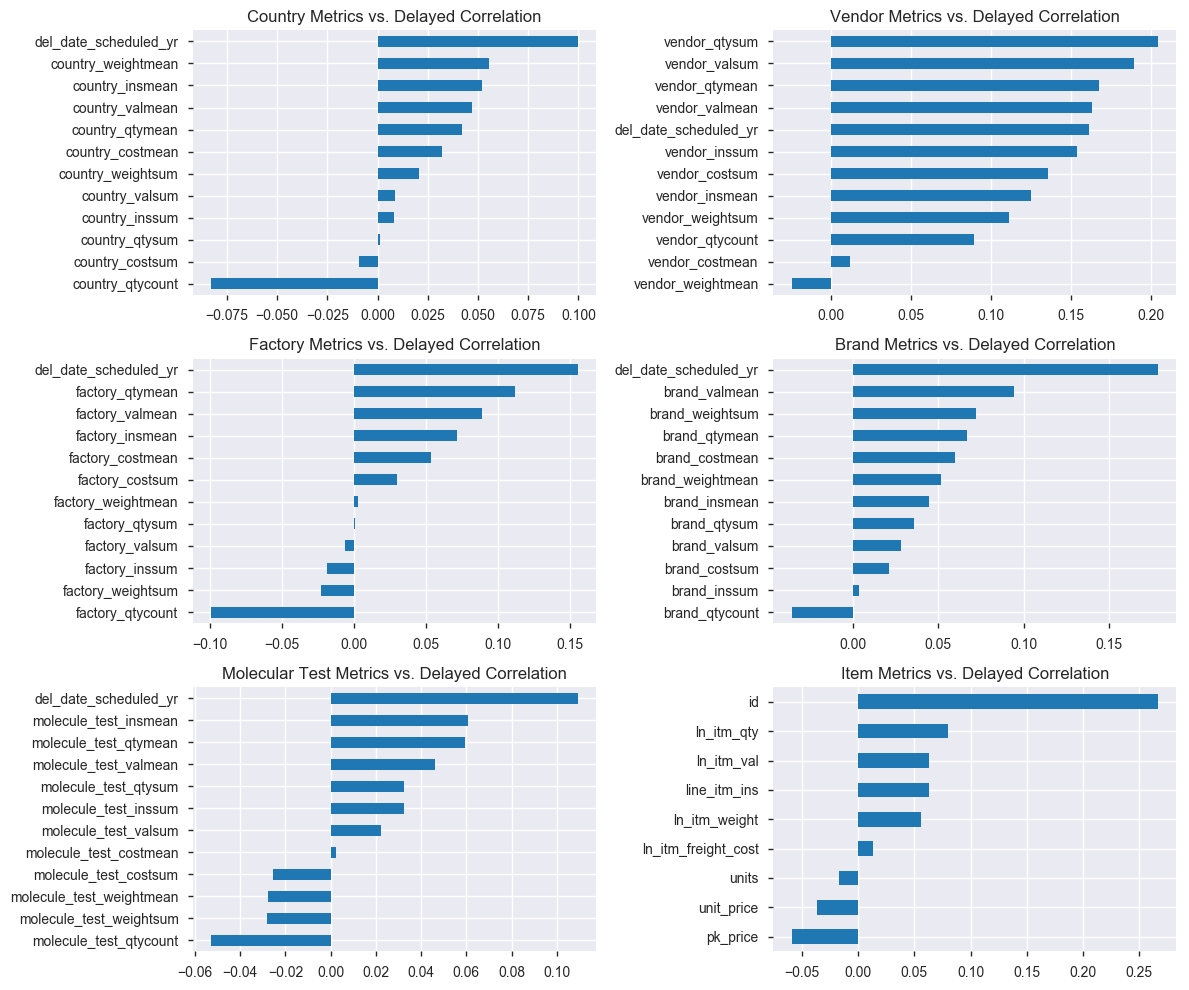

In [14]:
ndfs = [dnum_country, dnum_vendor, dnum_factory, dnum_brand, dnum_molecule_test, dnum]
ttl = ['Country', 'Vendor', 'Factory', 'Brand', 'Molecular Test', 'Item']
fig, ((ax0, ax1),(ax2,ax3),(ax4,ax5))= plt.subplots(nrows=3,ncols=2,figsize=(12,10))
axes = [ax0, ax1,ax2,ax3,ax4,ax5]
for i in range(len(ndfs)):
    pd.concat([ndfs[i],delayed], axis=1).corr().delayed.drop("delayed").sort_values().plot(kind='barh'
                ,title= ttl[i]+" Metrics vs. Delayed Correlation" ,ax = axes[i])
plt.tight_layout()

In [15]:
#dnum
sn =['ln_itm_qty', 'ln_itm_val', 'pk_price','line_itm_ins', 'ln_itm_weight']
# dnum_country
snc =  ['country_qtycount', #'country_qtymean',
        'country_valmean',# 'country_insmean',
       'country_weightmean'#,  'country_costmean'
       ]
# dnum_vendor
snv=[#'vendor', 'vendor_qtycount',
     'vendor_qtysum',
       'vendor_qtymean'
    #, 'vendor_valsum', 'vendor_valmean', 'vendor_inssum',
     #  'vendor_insmean', 'vendor_weightsum',  'vendor_costsum'
]
# dnum_factory
snf=[#'factory',
     'factory_qtycount', 
     'factory_qtymean'#, 'factory_valmean','factory_costmean'
    ]
#dnum_brand
snb = [#'brand',  'brand_qtymean',      
       'brand_valmean'
#       ,'brand_insmean', 'brand_weightsum', 'brand_weightmean', 'brand_costmean'
]
#dnum_molecule_test
snm=[#'molecule_test', 
     'molecule_test_qtycount'
     #,'molecule_test_qtymean', 'molecule_test_valmean'
     ,'molecule_test_insmean']

In [16]:
dn,dnc, dnv = dnum[sn],dnum_country[snc], dnum_vendor[snv] 
dnf, dnb, dnm = dnum_factory[snf],dnum_brand[snb],dnum_molecule_test[snm]
#dt, do

In [17]:
# dnum_lpi_fsi

In [18]:
dnum_lpifsi.head()

,dest_sum,dest_mean,dest_fsi,dest_customs,dest_infra,dest_intl_ship,dest_logistic_qlty,dest_lpi,dest_timeliness,dest_track_trace,...,orig_infra,orig_intl_ship,orig_logistic_qlty,orig_lpi,orig_timeliness,orig_track_trace,dest_del_date_scheduled_yr,dest_count,orig_del_date_scheduled_yr,orig_count
0,0.0,0.0,109.2,2.22222,2.22222,2.125,2.375,2.361346,3.25000,2.0,...,2.90476,3.07813,3.26563,3.070914,3.47458,3.03333,2006,14,2006,31
1,0.0,0.0,78.6,2.88889,2.50000,3.000,2.800,2.888855,3.22222,2.9,...,2.90476,3.07813,3.26563,3.070914,3.47458,3.03333,2006,12,2006,31
2,0.0,0.0,109.2,2.22222,2.22222,2.125,2.375,2.361346,3.25000,2.0,...,4.19133,3.90984,4.20728,4.098695,4.32727,4.11864,2006,14,2006,13
3,0.0,0.0,78.6,2.88889,2.50000,3.000,2.800,2.888855,3.22222,2.9,...,2.90476,3.07813,3.26563,3.070914,3.47458,3.03333,2006,12,2006,31
4,0.0,0.0,78.6,2.88889,2.50000,3.000,2.800,2.888855,3.22222,2.9,...,2.90476,3.07813,3.26563,3.070914,3.47458,3.03333,2006,12,2006,31


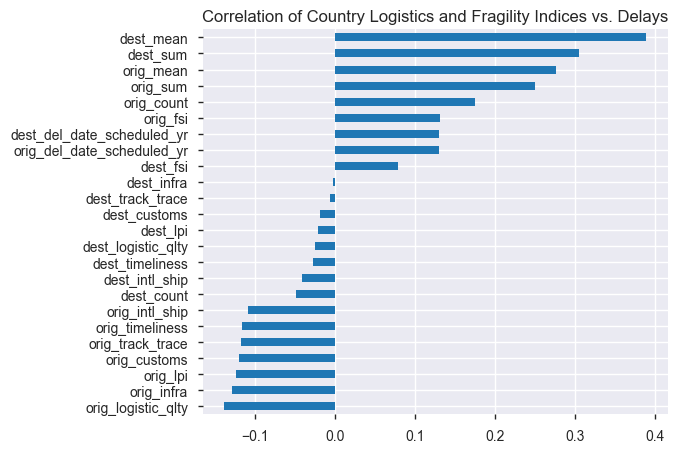

In [19]:
pd.concat([dnum_lpifsi, delayed],axis=1).corr()['delayed'].drop('delayed', axis=0).sort_values().plot(
        kind="barh", title="Correlation of Country Logistics and Fragility Indices vs. Delays"
    , figsize=(6,5))

#### Country Fragility and Fragility Indices correlate with Delays
- Very significant elements - interestingly different factors matter for orig vs. dest!
    - dest_mean, dest_sum, dest_count, orig_mean, orig_sum, orig_count, orig_fsi, year
    - dest_count, orig_intl_ship, orig_timeliness, orig_track_trace, orig_customs, orig_lpi, orig_infra, orig_logistic_qlty
    - About a third of the features, mostly destination are not very significant.
    - Very interesting indeed
    - Generally, the volumes, value of products/shipments is positively correlated with supply chain delays
    - More supply between fragile states is more likely to be delayed - with origin country having more influence 
    - On the other hand, the logistics quality are negatively correlated with delays with origin metrics having more weight than destination. Infact, destination logistics have minimal impact (about half that of origin)

In [20]:
snlf = [#'dest_mean', 'dest_sum', 'dest_count'
        #, 'orig_mean', 'orig_sum','orig_count',
    'dest_fsi','dest_intl_ship', 'dest_timeliness'
, 'dest_track_trace', 'dest_customs', 'dest_lpi', 'dest_infra',
        'dest_logistic_qlty',
    'orig_fsi','dest_count','orig_intl_ship', 'orig_timeliness'
, 'orig_track_trace', 'orig_customs', 'orig_lpi', 'orig_infra',
        'orig_logistic_qlty']
dnlf = dnum_lpifsi[snlf]

### Categorical Data Exploration

In [21]:
# x=cat_cols[11]
# f, c= plt.subplots(1,1,figsize=(15,35))
# sns.boxplot(data=df, x=x, y = yvals[0], hue=yvals[1], ax=c)
# for item in c.get_xticklabels():
#     item.set_rotation(90)

In [22]:
so =[ #'pq_date_new_yr', 'pq_date_new_mn', 'pq_date_new_dy',
 'po_date_new_yr', 'po_date_new_mn', 'po_date_new_dy',
  'del_date_scheduled_mn', 'del_date_scheduled_dy'
 #, 'del_date_client_yr', 'del_date_client_mn','del_date_client_dy'
 #, 'del_date_recorded_yr', 'del_date_recorded_mn','del_date_recorded_dy'
 #, 'pq_date_new_wd', 'pq_date_new_wk','pq_date_new_qt'
 , 'po_date_new_wd', 'po_date_new_wk', 'po_date_new_qt'
 ,'del_date_scheduled_wd', 'del_date_scheduled_wk','del_date_scheduled_qt'
 #, 'del_date_client_wd', 'del_date_client_wk','del_date_client_qt'
 #, 'del_date_recorded_wd', 'del_date_recorded_wk','del_date_recorded_qt'
 #, 'delayed'
 #, 'proj_code', 'pq_no', 'po_no','ship_no'
 #, 'country'
    , 'mngr', 'fulfill_via', 'vendor_terms'
 ,'ship_mode'
 #, 'pq_date'
 #, 'po_date'
    , 'prod_grp', 'sub_class'
    , 'vendor'
 #,'itm_desc'
 , 'molecule_test', 'brand', 'dosage'
 , 'dosage_form','factory'
    , 'first_line'
 #, 'weight', 'freight_cost'
 ,'del_date_scheduled_yr', 'ship_config', 'weight_captured_seperately'
 ,'freight_invoiced_seperately', 'freight_in_cmdty_cost'
 #,'factory_address'
 , 'origin_country'
    , 'origin_continent'
 #, 'name'
 , 'dest_country'
# , 'orig_origin_country'
]
do =  dobject[so]

### Merge all data

### Make Pipeline

In [23]:
# Import pipeline and preprocessing modules 
from sklearn.preprocessing import FunctionTransformer,PolynomialFeatures, normalize
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, LabelBinarizer ,StandardScaler
from sklearn.pipeline import TransformerMixin, _BaseComposition 
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline

In [24]:
log1p = FunctionTransformer(np.log1p)
make_num_pipe = make_pipeline(log1p, StandardScaler()) 
make_num_pipe_2 = make_pipeline(#log1p, 
                                StandardScaler()) 
make_cat_pipe = make_pipeline(mhf.Dummifier())
make_lab_pipe = make_pipeline(mhf.Labeler())

In [25]:
# Drop redundant columns
entities =['country', 'factory', 'vendor', 'brand', 'molecule_test']
for d in [dnc, dnf, dnv, dnb, dnm]:
    for c in entities:
        try:
            d.drop(c, axis=1, inplace=True)
        except:
            pass
dn,dnc, dnf, dnv, dnb, dnm = [pd.DataFrame(make_num_pipe.fit_transform(d), index=d.index
                            , columns=d.columns) for d in [dn,dnc, dnf, dnv, dnb, dnm]]
dnlf = pd.DataFrame(make_num_pipe_2.fit_transform(dnlf), index=dnlf.index,columns=dnlf.columns)
dtr = pd.DataFrame(make_num_pipe_2.fit_transform(dtrend), index=dtrend.index,columns=dtrend.columns)
y = make_lab_pipe.fit_transform(dobject.delayed.map({True:1, False:0}))
try:
    do.drop('delayed', axis=1, inplace=True)
except:
    pass
do = make_cat_pipe.fit_transform(do)
data = pd.concat([do,dnlf,dn,dnc, dnv, dnf, dnb, dnm, dtr], axis=1)
print(data.shape,ddate.columns)
# Remember the date df will come in handy later for regression

(10324, 719) Index(['del_date_scheduled', 'del_date_client', 'del_date_recorded', 'pq_date',
       'po_date', 'po_date_new', 'pq_date_new', 'anticipated_lead_time',
       'actual_lead_time', 'delivery_delay_time'],
      dtype='object')


In [26]:
#[d.describe() for d in [dn,dnc, dnf, dnv, dnb, dnm, dtrend]]

---
# 2. Feature Selection
---

In [27]:
# Import modules for feature selection
from sklearn.feature_selection import SelectKBest, RFECV, SelectFromModel, VarianceThreshold, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import pca
from sklearn.manifold import isomap

### Dimensionality Reduction
### *Principal Components Analysis*


Explained Ratios:
 [ 0.174422    0.14235451  0.06085945  0.05006526] 
--- 
 TOP 4 Dims Explained Variance:
 0.42770121760357555 
--- 
Total Explained Variance:
 0.42770121760357555


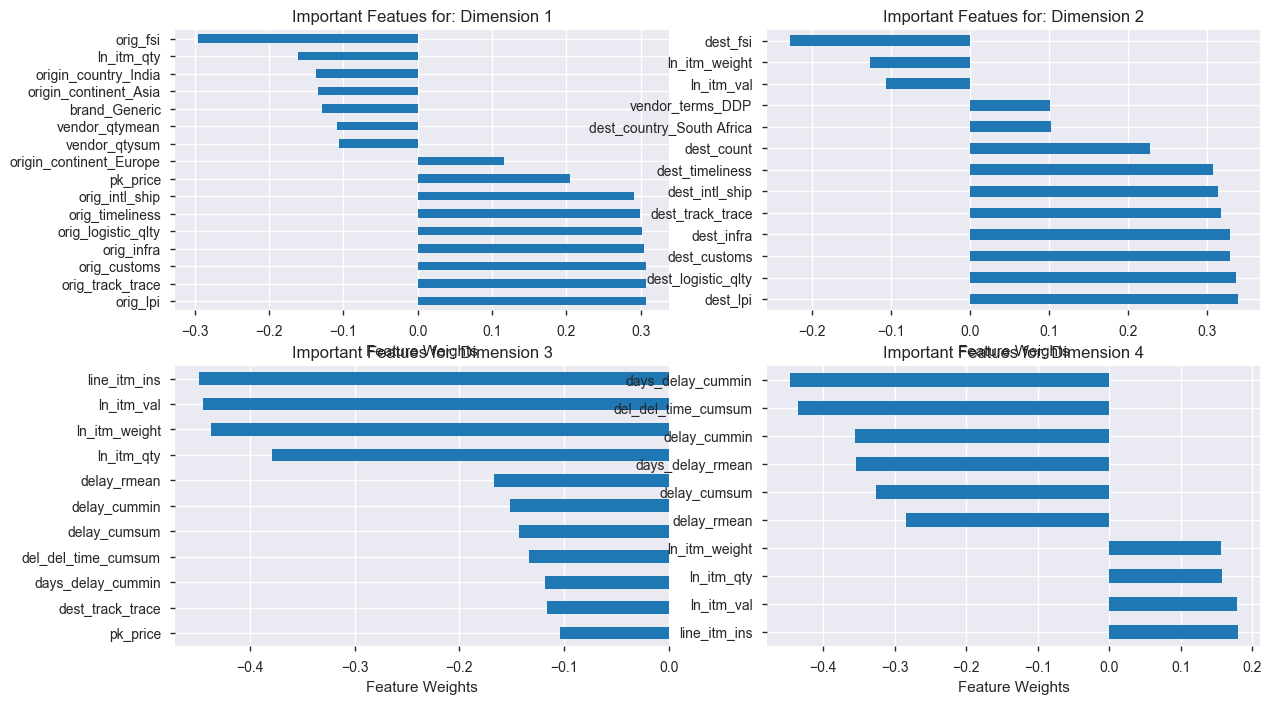

In [28]:
# Try the following and make sure to plot:
#PCA #Isomap
mypca = pca.PCA(n_components=4)
mypca.fit(data)
mypca.transform(data)

print( "\nExplained Ratios:\n {} \n--- \n TOP 4 Dims Explained Variance:\n {} \n--- \nTotal Explained Variance:\n {}" 
    .format(mypca.explained_variance_ratio_
            ,mypca.explained_variance_ratio_[:4].sum(),mypca.explained_variance_ratio_.sum()))
# pca_output = pca_results(data, mypca)

# Plot the dimensions of PCA Components
# with the top contribution features i.e. >10%
mhf.pca_results(data,mypca)

**Principal Components Analysis:**

** Explained Variance**

- The first and second principal components explain ~ 31% (see above) of the total variance in the data, which is quite significant

- The first four principal components explained almost 43% (see above) of the data which is not all of the variance in the data but significant enough to inform a model.

**Supply Chain characteristics across the four major dimensions**

- **Dimension1**: This dimension explains about 17% of the variance in the data. Looking at the composite features, one can see that these are the **Supply-side factors** which explain a lot of the variation e.g. origin geography characteristics like logistics quality and fragility of the state, vendor volumes, brand and prices.
- **Dimension2**: This dimension explains about 14% of the variance in the data. These factors are mostly about **the Customer** e.g. destination geography, logistics and volumes, receipient clients etc.
- **Dimension3**: This dimension explains about 6% of the variance in the data. It is mainly influenced by **product/item level** details, product value, and specifications as well as history of delay in delivery
- **Dimension4**: This dimension explains about 5% of the variance in the data. It is also mainly influenced by **product/item level** details in a slightly different way history and trends of being delayed etc.


### Feature Importances - Random Forest

(719, 2)


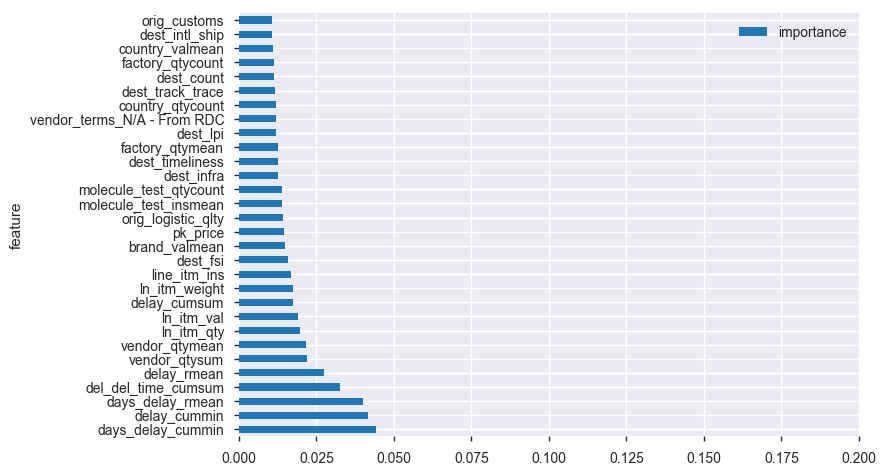

In [29]:
rfc = RandomForestClassifier(random_state=121)
X,y = data, y
rfc.fit(X,y)

# Extract feature importances into a df
features_rfc = X.columns
key_features_rfc = pd.DataFrame(rfc.feature_importances_, features_rfc)
rfc_idx = range(len(key_features_rfc))
key_features_rfc.reset_index(inplace=True)
key_features_rfc.columns=['feature', 'importance']
print(key_features_rfc.shape)
key_features_rfc.set_index('feature').sort_values('importance'
                                , ascending=False)[:30].plot(kind="barh", xlim=(0,0.2))

In [30]:
# Total Variation Explained by first 30 features...
key_features_rfc.set_index('feature').sort_values('importance'
                                , ascending=False)[:30].sum()

importance    0.547919
dtype: float64

#### Random Forest Findings - Most Important Features

- Remember it's OK to see the relatively small feature importances, especially if there is some collinearity
- This is because colinear featureshave toshare the contribution/importance. If we were looking to use linear regression, then this would need to be solved i.e. make several combination features to combine the importance/variance into one feature. But ensemble methods like Random Forest can deal with this very easily.
- Top features are as listed in the chart (**Overall, findings consistent with Principal Component Analysis** :
    - The lagged, cumulative sums, min as well as the lagged rolling mean of delays as well as delay lenght(days)
    - Supply factors like vendor volumes and quantities follow. This is very consistent with the Principal component analysis findings. Brand elements/influence is also quite visible
    - Product-level characteristics like value, quantity and price come up afterwards, mixed with some client-side factors like destination country stability and logistics, and origin logistics and quality


---
# Checkpoint 2: 
### Next section: Model Pipeline, Benchmark & Selection
---